# SLU06 - Dealing with Data Problems

[1. Introduction to data cleanup](#section-1)   
&emsp;[1.1 Clean data](#section-1-1)   
[2. Tidy Data](#section-2)   
&emsp;[2.1 Problem: Column headers are values, not variable names](#section-2-1)   
&emsp;[2.2 Problem: Multiple types of observational units are stored in the same table](#section-2-2)   
[3. Data entry problems](#section-3)   
&emsp;[3.1 Data entry problems in categorical variables](#section-3-1)   
&emsp;&emsp;[3.1.1 String operations](#section-3-1-1)   
&emsp;[3.2 Data entry problems in numerical variables](#section-3-2)   
&emsp;[3.3 Applying functions to columns and rows](#section-3-3)   
&emsp;[3.4 Duplicated entries](#section-3-4)   
[4. Missing values](#section-4)   
&emsp;[4.1 How to detect missing values](#section-4-1)   
&emsp;[4.2 Handling missing values](#section-4-2)   
&emsp;&emsp;[4.2.1 Drop missing values](#section-4-2-1)   
&emsp;&emsp;[4.2.2 Impute missing values for numerical variables](#section-4-2-2)   
&emsp;&emsp;[4.2.3 Replace outliers](#section-4-2-3)   
&emsp;&emsp;[4.2.4 Impute missing values for categorical variables](#section-4-2-4)   
&emsp;&emsp;[4.2.5 Flag missing values](#section-4-2-5)   
&emsp;[5. Further reading](#section-5)

## 1. Introduction to data cleanup <a name="section-1"></a>

In a real world scenario, **data is almost never ready** for exploratory analysis, visualization, or modeling. The world is messy, and so is it's data. Data problems arise from problems in data collection and data entry. It is not always possible to correct all of them.

Cleaning messy data often ends up consuming the majority of the data scientist's time. On average, 80 percent of the time is spent ensuring that your data is in a clean and workable form, while just 20 percent is dedicated to visualizing and analyzing data, creating machine learning models, or other advanced analytics. **Data cleaning is always the first step** when building a machine learning model. 

Although time consuming, data cleaning saves costs down the line. Ideally, thinking about clean data should start when planning the data collection, but unfortunately the data scientist usually has no influence on this step. According to the 1-10-100$ principle, the cost of correcting bad data is ten times more than the cost of preventing bad data, and the cost of fixing a problem generated by bad data is 100 times more.

***No models create meaningful results with messy data - garbage in, garbage out.***

<img src="media/clean-you-must.jpg"/>

### 1.1 Clean data <a name="section-1-1"></a>

Clean data is:

- **tidy**: correctly structured in tables
- **valid**: the values make sense and have the correct datatype and range, e.g. the age of a person is numerical and between 0 and 130 years
- **accurate**: the values correspond to reality, e.g. the customer address is correct
- **complete**: there are no missing values
- **consistent**: does not contain contradictory entries, e.g. children are younger than parents
- **uniform**: the units across the dataset are the same, e.g. all distances are expressed in km

**Data cleaning** aims to achieve the above criteria and additionally correct syntax errors, eliminate duplicate entries, standardize entries, scale and normalize numerical data, and deal with outliers. In this notebook, you will learn about the techniques necessary to achieve some of these goals. Nonetheless, depending on the nature of the data, it is not always possible to achieve them all. At the same time, this is the **opportunity to really get to know your dataset and document it**. Except for this SLU, you will learn more about data cleaning in SLU12 and S02.

Roll up your sleeves, 'cause things are about to get messy...

In [1]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(3.5,3.5)

## 2. Tidy data <a name="section-2"></a>

The **structure** of a tidy dataset is related to its **meaning**:

* each **variable** is a *column*
* each **observation** is a *row*
* each **cell** is a *single measurement*
* each **type of observational unit** is a *table*

<img src="media/tidy-data.png"/>

Let's spend a minute thinking about these concepts. In data science, constructing a **model** means to find a **relationship** between a number of **variables** and an **outcome** (which is also a variable from the point of view of tidy datasets). Each column of a tidy dataset consists of values measured for the same variable (like height) across multiple units (people). Each row consists of values measured on the same unit (like person) across multiple attributes (height, age, ...). In some cases it is completely obvious what are the variables, in others it requires some deliberation to identify them.

A simple **example of a model** is the dependence of an apartment price on the number of rooms, the apartment area and the apartment location. In this example, the **variables** are the numbers of rooms, the area, and the location. The **outcome** is the price. To efficiently deal with this dataset, it should be stored in a **table** (represented by a pandas dataframe) with **four columns**, one for each of the **three variables** and one for the **outcome**. **Each row** of the dataframe should contain the values of all variables and the outcome for one **observation** (one apartment).

One immediately obvious advantage of tidy datasets is that the **values for different observations and variables can be accessed in the same way** - using the column/row addressing of dataframes. Tidy datasets are also easy to manipulate, model and visualize using **tidy tools**. Tidy tools are functions and methods that expect tidy inputs and produce tidy outputs, like many of those in pandas.

<img src="https://imgs.xkcd.com/comics/exploits_of_a_mom.png" />

Datasets that are **not tidy** are **messy**. The **most common problems of messy datasets** are the following:

1) Column headers are values, not variable names;   
2) Multiple variables are stored in one column;   
3) Variables are stored in both rows and columns;   
4) Multiple types of observational units are stored in the same table;   
5) A single observational unit is stored in multiple tables;   


These problems are solved using the techniques of **melting, unstacking, string splitting, and table splitting and joining**. In this notebook, we will employ melting and string splitting to solve the problems number 1) and 4). The exercise notebook has an example of problem 2), and problem 5) together with table splitting and joining will be covered in BLU02. 

### 2.1 Problem: Column headers are values, not variable names <a name="section-2-1"></a>

In the dataset below, we have two variables: `religion` and `income`.
The tidy data criterion is not fulfilled because **the `income` variable is represented as multiple columns, instead of just one column**.

In [2]:
df_messy_1 = pd.read_csv(os.path.join('data', 'column_headers_are_values.csv'), sep=' ')
df_messy_1

,religion,<$10k,$10-20k,$20-30k,$30-40k,$40-50k,$50-75k
0,Agnostic,27,34,60,81,76,137
1,Atheist,12,27,37,52,35,70
2,Buddhist,27,21,30,34,33,58
3,Catholic,418,617,732,670,638,1116
4,Don’t know/refused,15,14,15,11,10,35
5,Evangelical Prot,575,869,1064,982,881,1486
6,Hindu,1,9,7,9,11,34
7,Historically Black Prot,228,244,236,238,197,223
8,Jehovah’s Witness,20,27,24,24,21,30
9,Jewish,19,19,25,25,30,95


This kind of arrangement is useful for presentations, but not for analysis. It makes it kind of complicated to answer questions like:

&nbsp;&nbsp;&nbsp;&nbsp;"*How many people of the Buddhist religion earn between \\$10k and \\$40k?*".

In [3]:
# How many people with the Buddhist religion earn between $10k and $40k? - with messy data
df_messy_1[df_messy_1.religion == 'Buddhist'][['$10-20k', '$20-30k', '$30-40k']].sum(axis=1).values[0]

85

The above query is very unnatural: first we're subsetting rows to get the right religion, then we subset columns to get the right income values, and finally we do a sum to get the counts.

We can **tidy up this data** using the method [`melt()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html). The technique is called **melting** or **stacking** and it concatenates the values from the multiple `income` columns into one.

In [4]:
# Getting the income values from the column names
income_values = [x for x in df_messy_1.columns.tolist() if x!='religion']
print(f"Income values stored in the columns:\n{income_values}")

# Using the melt function to 'melt' the income_values into a column
df_tidy_1 = pd.melt(df_messy_1, id_vars=['religion'], value_vars=income_values, var_name='income', value_name='freq')
df_tidy_1.head(15) #showing the top 15 observations

Income values stored in the columns:
['<$10k', '$10-20k', '$20-30k', '$30-40k', '$40-50k', '$50-75k']


,religion,income,freq
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15
5,Evangelical Prot,<$10k,575
6,Hindu,<$10k,1
7,Historically Black Prot,<$10k,228
8,Jehovah’s Witness,<$10k,20
9,Jewish,<$10k,19


Let's look at what happened in the `melt` function in more detail:
- The `id_vars` parameter lists the columns that already were variables in the messy dataset and that we'd like to keep (also called colvars). The values in these columns are repeated as necessary.
- The `value_vars` parameter lists columns that were in fact values and that we wanted to transform into the values of a newly created column `income` as indicated in the `var_name` parameter.
- The values from the `value_vars` columns were concatenated into a new column called `freq` as indicated in the `value_name` parameter.

Now, obtaining the answer to the same question is much easier:

In [5]:
# How many people with the Buddhist religion earn between $10k and $40k? - with tidy data
df_tidy_1[(df_tidy_1.religion == 'Buddhist') & (df_tidy_1.income.isin(['$10-20k', '$20-30k', '$30-40k']))].freq.sum()

85

We needed to subset only rows this time and the query becomes much easier to understand: first we subset the rows with the desired value for religion and income, then we sum the frequencies to get the final value.

### 2.2 Problem: Multiple types of observational units are stored in the same table <a name="section-2-2"></a>

Let's get another messy dataset:

In [6]:
df_messy_2 = pd.read_csv(os.path.join('data', 'multiple_types.csv'))
df_messy_2

,year,artist,track,time,date.entered,wk1,wk2,wk3
0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,87,82,72
1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,91,87,92
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,81,70,68
3,2000,A*Teens,Dancing Queen,3:44,2000-07-08,97,97,96
4,2000,Aaliyah,I Don't Wanna,4:15,2000-01-29,84,62,51
5,2000,Aaliyah,Try Again,4:03,2000-03-18,59,53,38
6,2000,"Adams, Yolanda",Open My Heart,5:30,2000-08-26,76,76,74
7,2000,"Aguilera, Christina",I Turn To You,4:00,2000-04-15,50,39,30


This is a subset of a music billboard dataset: **each row is a song in the billboard, and the columns have information about the following variables**:
* `year` of the billboard
* `artist`
* `track` name
* `time`, which is the track duration 
* `date.entered`, which is the date when the song entered the billboard
* `wk1`, `wk2` and `wk3`: the rank of the song in each week after it entered the top 100 (we're showing only the first three weeks here, the original dataset goes to week 75)

This dataset is not tidy, but is very useful for data entry - the ranking of the song is added to the week columns as long as it remains in the billboard.

The dataset first needs melting - **the `wk1`, `wk2` and `wk3` columns all refer to the same variable, which is the rank of the song in the billboard in weeks since it entered top 100**. The `melt()` function takes care of it again.

In [7]:
id_vars = ['year', 'artist', 'track', 'time', 'date.entered']
value_vars = ['wk1', 'wk2', 'wk3']
df_melted = pd.melt(df_messy_2, id_vars=id_vars, value_vars=value_vars, var_name='week', value_name='position')
df_melted.sort_values(['artist', 'week']).head(10)

,year,artist,track,time,date.entered,week,position
0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk1,87
8,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk2,82
16,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26,wk3,72
1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk1,91
9,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk2,87
17,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02,wk3,92
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk1,81
10,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk2,70
18,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk3,68
3,2000,A*Teens,Dancing Queen,3:44,2000-07-08,wk1,97


Now we've created the problem we wanted to demonstrate in this section - **two observational units in the same table** - one is the song itself, the other is its billboard rank at a certain point in time. The consequence is that the song data is repeated. This is not a good idea - it may lead to inconsistent data when the same information is accidentally modified in different entries.

**It is better to split these two types of observational units into two tables**. However, we should have **a way to relate the two units**. We need to maintain a correspondence, a **mapping id**, for these two tables for when we need to use information from both tables. As our table doesn't have a unique id, we have to create one. 

Let's go back to the original messy dataset and start tidying up again. First, we divide the dataset into a song table and a rank table, then melt the rank table.

In [8]:
# We create an id for each song, then copy the song data to another table
df_messy_2['song_id'] = range(len(df_messy_2))
df_songs = df_messy_2[['song_id'] + id_vars]
df_songs

,song_id,year,artist,track,time,date.entered
0,0,2000,2 Pac,Baby Don't Cry (Keep Ya Head Up II),4:22,2000-02-26
1,1,2000,2Ge+her,The Hardest Part Of Breaking Up (Is Getting Ba...,3:15,2000-09-02
2,2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08
3,3,2000,A*Teens,Dancing Queen,3:44,2000-07-08
4,4,2000,Aaliyah,I Don't Wanna,4:15,2000-01-29
5,5,2000,Aaliyah,Try Again,4:03,2000-03-18
6,6,2000,"Adams, Yolanda",Open My Heart,5:30,2000-08-26
7,7,2000,"Aguilera, Christina",I Turn To You,4:00,2000-04-15


In [9]:
# We keep the positions per week and the song_id in another table, then melt the week columns
df_rank = pd.melt(df_messy_2, id_vars=['song_id'], value_vars=value_vars, var_name='week', value_name='position')
df_rank = df_rank.sort_values(['song_id', 'week']).reset_index(drop=True)
df_rank.head()

,song_id,week,position
0,0,wk1,87
1,0,wk2,82
2,0,wk3,72
3,1,wk1,91
4,1,wk2,87


Look at that! Two beautiful **tidy** datasets!

Now that we learned how to tidy up problems in the structuring of datasets, we'll move on to dealing with problems in the values of the datasets - their validity, accuracy, completeness, consistency, uniformity, and missing and duplicated values.

## 3. Data entry problems <a name="section-3"></a>

<img src="media/monkey.gif"/>

**To err is not only human, but also expected.**  Typical data entry problems are:
- Case mismatches and grammar errors in text fields
- Wrong datatypes
- Non-sense values (AKA *“I really don’t know what to write here but this form forces me to write something...”*)
- Missing values
- Duplicate observations
- Lack of standardization (like dashes and slashes in phone numbers or Port. and PT for Portugal)
- Extra white spaces
- Information irrelevant for the given analysis

Many of these can be prevented at data collection by enforcing certain format or by checking for datatypes and consistency, but as a data scientist you don't always have influence on this part.    
In this section, you will learn how get an overview of variable values to detect possible problems, then use string and mathematical operations to correct them.

The following dataset illustrates some of those problems:

In [10]:
data = pd.read_csv(os.path.join('data', 'data_with_problems.csv'), index_col=0)
print(f"This dataset has {len(data)} observations.")
print("Here are the top 10:")
data.head(10)

This dataset has 203 observations.
Here are the top 10:


,age,height,gender,birthdate
CFLOXRHMDR,88.0,163.0,female,1942-02-27
FXLJSNLSOG,29.0,158.0,female,1946-03-31
FWDIVJKGOI,42.0,159.0,female,1946-09-13
YWEBKQWHRE,25.0,179.0,male,1947-08-25
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
SSZQEGTLNK,NaN,162.0,male,1959-01-22
PRFEFXNGWN,36.0,166.0,female,1962-04-16


Based on the names of the variables (columns), we can assume that each observation (row) represents a person. In this dataset, we have:

* 4 variables: **age**, **height**, **gender**, and **birthdate**
    * The gender variable is categorical,  and the other three are numerical.
* 203 observations

Let's recall the difference between categorical and numerical variables: 
- **numerical** variables take values that are numbers. The values have a natural order. In theory, there is an infinite amount of values to choose from, but in practice, the values are often restricted to a certain range.
- **categorical** variables take values from a finite set of values which are not ordered. Categorical values are sometimes coded as numbers, but that doesn't make them ordered. We could code the gender variable values as 0 and 1, but it doesn't make sense to say that gender 1 is larger than gender 0.

SLU12 has more information on variable types and how to deal with them when building statistical models.

### 3.1 Data entry problems in categorical variables <a name="section-3-1"></a>

Let's look at the categorical variable `gender`. The first step is to get an overview of the values of the variable and detect the problems. Two useful functions are [nunique](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html) to see how many unique values we have and [value_counts](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) to count the number of entries for each unique value.

- **nunique()**

In [11]:
data['gender'].nunique()

7

7 - that's an odd number. Most datasets will have 2-4 (female, male, non-binary, prefer not to tell). Let's see what they are:

- **value_counts()**

In [12]:
data['gender'].value_counts()

female       111
male          67
MALE           9
m              3
F              2
f              1
   female      1
Name: gender, dtype: int64

Ok... Most of the observations have gender either with *female* or *male* values, but there are some cases where we have different values: MALE, m, F, f, &nbsp;&nbsp;&nbsp;female (*with leading blank spaces!!*). A clear case of insufficient crosschecking at data entry.

By default, `value_counts` doesn't take into consideration missing data. We can change this by passing the `dropna` attribute as `False`. 

In [13]:
data['gender'].value_counts(dropna=False)

female       111
male          67
NaN            9
MALE           9
m              3
F              2
f              1
   female      1
Name: gender, dtype: int64

No missing data here.

### 3.1.1 String operations <a name="section-3-1-1"></a>

To clean this data, we can do **string operations** directly on the dataframe (*much magic! such wow!*).
We can apply **python string methods** to all the elements in a pandas Series by calling `.str` on the Series, followed by the string method. The first steps are usually the conversion to lowercase or uppercase and white space removal. Then we may need to filter out or replace characters and split or concatenate the strings.

- **str.lower() and str.upper()**

Let's convert all the strings in the `gender` column to lower case, using [`str.lower`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.lower.html).

In [14]:
data['gender'] = data['gender'].str.lower()
data['gender'].value_counts()

female       111
male          76
f              3
m              3
   female      1
Name: gender, dtype: int64

As we can see, this converted all the cases of `MALE` (which were 9) to `male` (before: 67 observations, after: 76 observations). Also, all the cases of `F` (which were 2), were converted to `f` (before: 1 observation, after: 3 observations).

[`str.upper`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.upper.html) does exactly the opposite: converts the strings to uppercase.

In [15]:
data['gender'].str.upper().value_counts()

FEMALE       111
MALE          76
F              3
M              3
   FEMALE      1
Name: gender, dtype: int64

- ##### str.strip()

Another useful method is [`str.strip`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.strip.html). It removes leading and trailing whitespaces from the strings. Let's try it out:

In [16]:
data['gender'] = data['gender'].str.strip()
data['gender'].value_counts()

female    112
male       76
f           3
m           3
Name: gender, dtype: int64

The string &nbsp;&nbsp;&nbsp;`female` with leading whitespaces was converted to `female` without the whitespaces - yey! 

- **str.replace()**

Next we need to replace `m` with `male` and `f` with `female`. We can do that using the [`str.replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html) method that receives as arguments a **pattern** and a **replacement** string. The pattern can be a regular expression ([regex](https://www.debuggex.com/cheatsheet/regex/python)).

In [17]:
# Note that here we're not changing the values in data.gender, we're just outputting them!
data['gender'].str.replace('m', 'male').value_counts()

femaleale    112
maleale       76
f              3
male           3
Name: gender, dtype: int64

Wait... something is wrong!

`str.replace()` replaces **any** occurrences of the pattern in the Series values, even if they appear in the middle of something. We can fix this in two ways.

**First option**: using a **regex** to specify that we want to replace the string `m` with `male`, but only when it appears alone. `^` and `$` mean beginning and end of string, respectively.

In [18]:
data['gender'].str.replace('^m$', 'male').value_counts()

female    112
male       79
f           3
Name: gender, dtype: int64

We can chain replacement operations together in order to handle the `m` and `f` replacements at the same time.
Notice that we need to call `.str` for each operation.

In [19]:
data['gender'].str.replace('^m$', 'male').str.replace('^f$', 'female').value_counts()

female    115
male       79
Name: gender, dtype: int64

**Second option**: instead of using the `str.replace` method, we can use pandas `replace()` method. It receives as argument a **dictionary** with the full-word replacements we want to do.

In [20]:
data['gender'] = data['gender'].replace({'m': 'male', 'f': 'female'}) # this time the changes are being saved!
data['gender'].value_counts()

female    115
male       79
Name: gender, dtype: int64

Looking good!

- **str.split() and str.cat()**

We've seen how to use some string methods directly on Series. There are many more string methods available, but we'll just see two more, str.cat and str.split, and apply it to the birthdate column.

We can use the [`str.split()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html) method to split the birthdate into three variables, **year**, **month** and **day**, which is much more practical for data manipulation purposes.

In [21]:
dates = data.birthdate.str.split(pat='-', expand=True)  # the pat argument receives the string
dates.columns = ['year', 'month', 'day']                # where the split is made.
dates.head()                                            # expand means the split happens at all occurences of pat

,year,month,day
CFLOXRHMDR,1942,02,27
FXLJSNLSOG,1946,03,31
FWDIVJKGOI,1946,09,13
YWEBKQWHRE,1947,08,25
YPUQAPSOYJ,1954,01,24


And just for fun, we can merge it back together with another separator using [`str.cat()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.cat.html):

In [22]:
dates['month_year'] = dates.month.str.cat(dates.year, sep='/')
dates.head()

,year,month,day,month_year
CFLOXRHMDR,1942,02,27,02/1942
FXLJSNLSOG,1946,03,31,03/1946
FWDIVJKGOI,1946,09,13,09/1946
YWEBKQWHRE,1947,08,25,08/1947
YPUQAPSOYJ,1954,01,24,01/1954


### 3.2 Data entry problems in numerical variables <a name="section-3-2"></a>

Data entry problems can also happen in **numerical variables**. Let's go back to our dataframe and look closely at the feature `age`. Let's use the `describe()` method that you learned in SLU01 to look at the age distribution:

In [23]:
data[['age']].describe()

,age
count,1.940000e+02
mean,1.546424e+06
std,2.153874e+07
min,1.000000e+00
25%,2.100000e+01
50%,2.700000e+01
75%,3.600000e+01
max,3.000000e+08


It seems that the oldest person in our dataset is 300 millions years old, about 100 times older than humankind! Having as the baseline the [oldest person ever in the Guinness world records](https://www.guinnessworldrecords.com/world-records/oldest-person), let's set the maximum possible age at 123, and the lowest at 0 and see how many values are out of this range:

In [24]:
data['age'][(data['age'] < 0) | (data['age'] > 123)]

TSHRBGFOJU    300000000.0
SQYVEHAWSW          224.0
Name: age, dtype: float64

We can handle these values as if they were missing values. For that purpose, let's replace them with `np.nan`. 

In [25]:
data.loc[(data['age'] < 0) | (data['age'] > 123), "age"] = np.nan
data.loc[["TSHRBGFOJU", "SQYVEHAWSW"]]

,age,height,gender,birthdate
TSHRBGFOJU,NaN,184.0,female,1947-07-05
SQYVEHAWSW,NaN,166.0,male,1976-01-22


We will explain how to deal with missing values in section 4.

### 3.3 Applying functions to columns and rows <a name="section-3-3"></a>

With the `.str` functions, we could apply the string functions to whole columns. What if we want to apply any function to a row or column? Pandas methods `map()` and `apply()` let us do just that.   
Both of them are so-called syntactic sugar - they look pretty in code, but the operation behind them consists simply of looping through the column or row values and applying the given function everytime. Both methods are therefore very slow, except when using numpy vectorized functions with `apply()`. Let's see some examples.

Imagine that you'd like to calculate the square of the height column. It can be done using `map()` and the numpy `sqrt()` function. Notice that the function is passed without parenthesis.

In [26]:
data.age.map(np.sqrt)

CFLOXRHMDR    9.380832
FXLJSNLSOG    5.385165
FWDIVJKGOI    6.480741
YWEBKQWHRE    5.000000
YPUQAPSOYJ    5.656854
                ...   
VYAQBLJKXJ         NaN
BLAKTCGBMO    5.656854
ZNLRYQHPXJ    5.000000
XUAJJPLVOI    4.242641
TRMMGYEEPC    4.582576
Name: age, Length: 203, dtype: float64

`map()` operates on pandas Series and outputs a Series. The function can be a predefined function or a lambda function. See more details [here](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html).

`apply()` operates on DataFrames and returns a DataFrame or a Series.

In [27]:
data[['age','height']].apply(np.sqrt)

,age,height
CFLOXRHMDR,9.380832,12.767145
FXLJSNLSOG,5.385165,12.569805
FWDIVJKGOI,6.480741,12.609520
YWEBKQWHRE,5.000000,13.379088
YPUQAPSOYJ,5.656854,13.000000
...,...,...
VYAQBLJKXJ,NaN,12.845233
BLAKTCGBMO,5.656854,13.964240
ZNLRYQHPXJ,5.000000,12.449900
XUAJJPLVOI,4.242641,12.961481


The `axis` argument specifies if the function is applied to columns or rows. Here is an example for summing row values:

In [28]:
data[['age','height']].apply(sum, axis=1)

CFLOXRHMDR    251.0
FXLJSNLSOG    187.0
FWDIVJKGOI    201.0
YWEBKQWHRE    204.0
YPUQAPSOYJ    201.0
              ...  
VYAQBLJKXJ      NaN
BLAKTCGBMO    227.0
ZNLRYQHPXJ    180.0
XUAJJPLVOI    186.0
TRMMGYEEPC    177.0
Length: 203, dtype: float64

You can design any complicated lambda function combining the values from several columns. Here we multiply the `age` column by 2 then add a square root of `height`:

In [29]:
data[['age','height']].apply(lambda x:x['age']*2+np.sqrt(x['height']),axis=1)

CFLOXRHMDR    188.767145
FXLJSNLSOG     70.569805
FWDIVJKGOI     96.609520
YWEBKQWHRE     63.379088
YPUQAPSOYJ     77.000000
                 ...    
VYAQBLJKXJ           NaN
BLAKTCGBMO     77.964240
ZNLRYQHPXJ     62.449900
XUAJJPLVOI     48.961481
TRMMGYEEPC     54.489996
Length: 203, dtype: float64

Find out more about `apply()` [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html).

### 3.4 Duplicated entries <a name="section-3-4"></a>

Dealing with duplicated entries requires two steps:
1. Define what is a duplicate in the context of our problem;
2. Search for duplicated entries and drop them from the dataset.

<img src="media/meme-of-duplicate.jpg"/>

In our case, each row (observation) corresponds to a person, for which we know an ID (in the index), age, height, gender, and birthdate. **Duplicates** are cases where two or more rows are **exact matches**, i.e, **the index and the values in all the columns are the same**.

We can find duplicates using the [`duplicated()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html) method and drop duplicated data with [`drop_duplicates()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html).

In [30]:
# Can you find some duplicates in the 10 first observations?
data.head(10)

,age,height,gender,birthdate
CFLOXRHMDR,88.0,163.0,female,1942-02-27
FXLJSNLSOG,29.0,158.0,female,1946-03-31
FWDIVJKGOI,42.0,159.0,female,1946-09-13
YWEBKQWHRE,25.0,179.0,male,1947-08-25
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
SSZQEGTLNK,NaN,162.0,male,1959-01-22
PRFEFXNGWN,36.0,166.0,female,1962-04-16


In [31]:
duplicated_mask = data.duplicated(keep='first')

print('Number of duplicates:', duplicated_mask.sum())

Number of duplicates: 6


Notice the `keep='first'` in `data.duplicated(...)` means that **all the duplicates are flagged as True, except for the first**. For example, there are a total of 4 rows with index `YPUQAPSOYJ`, but only 3 in the duplicated_mask.

Which are the duplicated entries?

In [32]:
data[duplicated_mask]

,age,height,gender,birthdate
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
YPUQAPSOYJ,32.0,169.0,male,1954-01-24
ZNLRYQHPXJ,25.0,155.0,male,1984-03-13
XUAJJPLVOI,18.0,168.0,female,1996-04-30
TRMMGYEEPC,21.0,156.0,female,1957-03-12


These are the duplicated observations - for each of them, we have **at least** another one in our dataset:

In [33]:
data.loc['ZNLRYQHPXJ']

,age,height,gender,birthdate
ZNLRYQHPXJ,25.0,155.0,male,1984-03-13
ZNLRYQHPXJ,25.0,155.0,male,1984-03-13


How can we drop all duplicates except for the first occurrence?

In [34]:
print(f"Shape before dropping duplicates: {data.shape}")
data = data.drop_duplicates()
print(f"Shape after dropping duplicates: {data.shape}")

Shape before dropping duplicates: (203, 4)
Shape after dropping duplicates: (197, 4)


That was easy! ;) 

## 4. Missing values <a name="section-4"></a>

We learned how to fix data that is there, but what if it's just... missing? 

This is probably the biggest data problem we generally face. But worry not! There is a way.

<img src="media/missing-data.jpg" width="300"/>

Dealing with missing data is one of the most tricky but common parts of data cleaning. While many models can live with other problems of the data, **most models don’t accept missing data**.

### 4.1 How to detect missing values <a name="section-4-1"></a>

In order to find out where are the missing values, we can use the method [`isnull()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html) followed by [`sum()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sum.html) to count how many missing values we have per column.

In [35]:
data.isnull().sum()

age          11
height        4
gender        9
birthdate     0
dtype: int64

So in total we have 24 observations with missing data, in three variables.  We can also see it explicitly - the missing values are indicated with `True`.

In [36]:
data.head(10).isnull() # show just the first 10 rows

,age,height,gender,birthdate
CFLOXRHMDR,False,False,False,False
FXLJSNLSOG,False,False,False,False
FWDIVJKGOI,False,False,False,False
YWEBKQWHRE,False,False,False,False
YPUQAPSOYJ,False,False,False,False
SSZQEGTLNK,True,False,False,False
PRFEFXNGWN,False,False,False,False
IIVXDNOAIV,False,False,False,False
VVQYVNRAGQ,False,False,False,False
YVEDWPTEEB,False,False,False,False


The opposite to `isnull()` is `notnull()`, showing the values that are not missing:

In [37]:
data.head(10).notnull()

,age,height,gender,birthdate
CFLOXRHMDR,True,True,True,True
FXLJSNLSOG,True,True,True,True
FWDIVJKGOI,True,True,True,True
YWEBKQWHRE,True,True,True,True
YPUQAPSOYJ,True,True,True,True
SSZQEGTLNK,False,True,True,True
PRFEFXNGWN,True,True,True,True
IIVXDNOAIV,True,True,True,True
VVQYVNRAGQ,True,True,True,True
YVEDWPTEEB,True,True,True,True


We have seen how many missing values we have in each column. Now we'd like to see in which rows are they. To answer this question, we will use the python method [`any()`](https://docs.python.org/3/library/functions.html#any).

In [38]:
# For each row, we get True if any of the columns is null and False otherwise
mask = data.isnull().any(axis=1)

# Then wee select the rows for which the mask is True
data[mask]

,age,height,gender,birthdate
SSZQEGTLNK,NaN,162.0,male,1959-01-22
CWCFROPRFE,22.0,NaN,male,1978-03-23
TJQPFEFVVH,NaN,182.0,NaN,1990-07-24
PYHWLDVICX,NaN,181.0,female,1955-12-19
MLRPKGKACD,NaN,185.0,male,1997-09-13
TSHRBGFOJU,NaN,184.0,female,1947-07-05
SGMGUJEBNC,NaN,173.0,male,1956-06-08
EORSIPDIHA,21.0,NaN,male,1958-09-26
YZDOYNOXAF,NaN,144.0,female,1968-07-03
QXUGUHCOPT,101.0,196.0,NaN,1970-02-09


When there is a **small number of features** like here, we can visualize the missing data via [**heatmap**](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

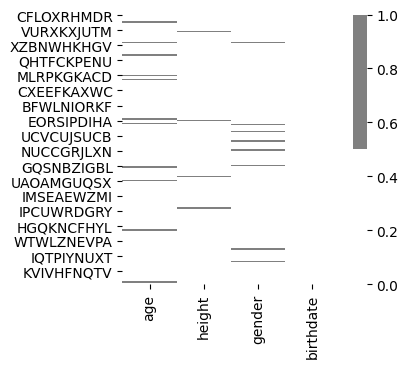

In [39]:
colours = ['#FFFFFF', '#808080'] # specify the colours - white is not missing, gray is missing.
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours));

An alternative to the heatmap is the **missing data histogram** which is a better option for data with many features. The code is a bit more complex but it allows you to only plot variables with missing data. It shows the number of missing values per row.

created missing indicator for: age
created missing indicator for: height
created missing indicator for: gender


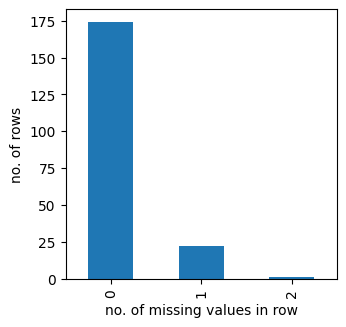

In [40]:
# first, for each column with missing data, create a new column indicating the missing values
missing_data=pd.DataFrame()
for col in data.columns:
    missing = data[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        missing_data['{}_ismissing'.format(col)] = missing
    missing_data.set_index(data.index)

# then, sum the missing values for each row
# and plot the histogram of missing values per row
ismissing_cols = [col for col in missing_data.columns if 'ismissing' in col]
missing_data['num_missing'] = missing_data[ismissing_cols].sum(axis=1)
missing_data['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing',
                                        xlabel='no. of missing values in row', ylabel='no. of rows', legend=False);

### 4.2 Handling missing values <a name="section-4-2"></a>

Dealing with missing data is not straightforward. It depends on the amount of missing data, on the reasons why it's missing and a bit on the opinion of the data scientist. Data can be missing for two reasons: it was not recorded (failure in data collection) or it does not exist (e.g. missing driving license number for children). There is no way to deal with non-existent data except for excluding it from the analysis. For not recorded data, there are basically three strategies: 
- **drop**: best stratedy when we have large amounts of missing values 
- **impute**: fill in based on the known values, makes sense with smaller amounts of missing data
- **flag**: indicate as missing with a new variable

### 4.2.1 Drop missing values <a name="section-4-2-1"></a>

The simplest way to handle missing values is to discard the rows with missing values. It is the preferred option when we have large amounts of missing values. We can do it using the method [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html). This method drops all the rows with any missing values from a DataFrame.

In [41]:
print(f"Shape before dropping missing values: {data.shape}")
data_no_missing_values = data.dropna()
print(f"Shape after dropping missing values: {data_no_missing_values.shape}")

Shape before dropping missing values: (197, 4)
Shape after dropping missing values: (174, 4)


If there are too many missing values in the same column, you can consider removing that variable from the analysis.

### 4.2.2 Impute missing values in numerical variables <a name="section-4-2-2"></a>

An alternative to dropping the rows that contain a missing value is to replace that value with another one. There are different strategies for numerical and categorical variables. For **numerical variables**, the simplest imputation is to fill in the **mean or median** of that variable. Median is the
safer option. It is the same as mean for normal distribution and works also for asymmetrical data. It is also less sensitive to outliers.

To see variable distributions, use plots such as boxplots or histograms, statistical tools to check for normal distribution, or descriptive statistics such as frequency tables (refer to SLU01, SLU03, and SLU04). The distribution for the variable `age`:

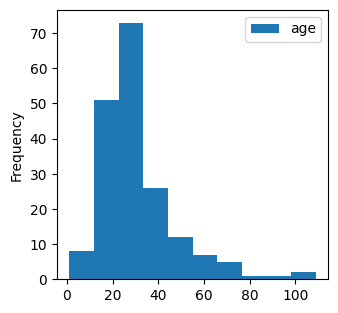

In [42]:
data['age'].plot.hist(legend=True);

We will use the method [`fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) to fill in the median:

In [43]:
print(f"Missing values in the age column before: {data.age.isnull().sum()}")
age_without_missing_values = data.age.fillna(data.age.median())
print(f"Missing values in the age column after: {age_without_missing_values.isnull().sum()}")

Missing values in the age column before: 11
Missing values in the age column after: 0


Pro tip: you can replace missing values for several variables using a dictionary:

In [44]:
data = data.fillna({
    'age': data.age.median(),
    'height': data.height.median()
})

Sometimes you can use a smarter imputation and use the mean or median from a cluster of similar observations instead of the entire population. For example, if you have missing values in the `height` feature, it might make more sense to replace the missing values according to the `gender` of each observation. Another more sofisticated imputation method for normal distributions is filling in with randomly generated data from the interval \[mean-std , mean+std\].

### 4.2.3 Replace outliers <a name="section-4-2-3"></a>

Outliers can be treated in the same way as missing data. In normal distributions, outliers are values more than 1.5 interquartile range away from the first or third quartile. Outlier removal should not be done automatically and should be based on a very good reason. Otherwise you might miss something important, such as the formation of a [hole in the ozone layer](https://www.math.uni-augsburg.de/htdocs/emeriti/pukelsheim/1990c.pdf). Some statistical models are more sensitive to outliers, for instance linear regression, in which case you should invest the effort to deal with them or use more robust methods.

### 4.2.4 Impute missing values for categorical variables <a name="section-4-2-4"></a>

For **categorical variables**, we can use similar replacement strategies as for numerical variables. We can fill in a random value or the value from the next row (we can also sort the rows by another variable beforehand). We can also use the most common value from a cluster of similar observations.

Let's replace the missing values in the `gender` with the previous valid value. We will use the `fillna()` method again and set the argument `method` to `backfill`:

In [45]:
print(f"Missing values in the gender column before: {data.gender.isnull().sum()}")
gender_without_missing_values = data.gender.fillna(method='backfill')
print(f"Missing values in the age column after: {gender_without_missing_values.isnull().sum()}")

Missing values in the gender column before: 9
Missing values in the age column after: 0


In [46]:
data.gender.value_counts(),gender_without_missing_values.value_counts()

(female    113
 male       75
 Name: gender, dtype: int64,
 female    118
 male       79
 Name: gender, dtype: int64)

Both values increased by a similar amount, as if we have filled them in randomly.

### 4.2.5 Flag missing values <a name="section-4-2-5"></a>

In principle, the fact that some values are missing is a piece of information. Filling them in makes us lose this information. A solution is to flag the values as missing. For numerical variables, we can use some placeholder number, like 0, to fulfill the technical requirement of no missing values then create another indicator variable for flags. For categorical variables, we can create a new category, for instance `missing`. Like this, we also don't allow pandas to trick us with **its default of ignoring missing values** :)

Let's flag the missing values in the `gender` column:

In [47]:
data.gender=data.gender.fillna('unknown')
data.gender.value_counts()

female     113
male        75
unknown      9
Name: gender, dtype: int64

That was a lot of cleaning and tidying up! Now it's time for you to get your hands dirty in the **Exercise Notebook**.

*Good luck!*

<img src="media/cleaning.gif"/>

### 5. Further reading <a name="section-5"></a>

[Hadley Wickham: Tidy data](https://vita.had.co.nz/papers/tidy-data.pdf) and the corresponding github [repo](https://github.com/hadley/tidy-data) with data

[Worldbank data cleaning checklist](https://dimewiki.worldbank.org/Checklist:_Data_Cleaning)